## **Check for GPU**

In [47]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## **Mount Google Drive**

In [48]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [46]:
# !wget https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

--2019-11-29 21:50:08--  https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.138, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM’

uc?id=0B7XkCwpI5KDY     [ <=>                ]   3.16K  --.-KB/s    in 0s      

2019-11-29 21:50:10 (46.0 MB/s) - ‘uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM’ saved [3240]



In [0]:
# import gzip
# import shutil
# with gzip.open('file.txt.gz', 'rb') as f_in:
#     with open('file.txt', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

## **Suppress Warnings**

In [0]:
import warnings
warnings.filterwarnings("ignore")

## **Imports**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout, CuDNNLSTM, TimeDistributed, Activation, CuDNNGRU
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras import initializers
import os
import numpy as np
import textwrap

%tensorflow_version 1.x

## **Project Constants**

In [0]:
PROJECT_DIR = '/content/gdrive/My Drive/MS_Project'
OUTPUT_DIR = '/content/gdrive/My Drive/MS_Project/Word_Level'

if not os.path.exists(PROJECT_DIR):
    os.path.mkdir(PROJECT_DIR)

if not os.path.exists(OUTPUT_DIR):
    os.path.mkdir(OUTPUT_DIR)

INPUT_FILE = 'LOR.txt'


In [70]:
HIDDEN_UNITS = 512
HIDDEN_LAYERS = 3

WEIGHT_FILE_NAME = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L' 
WEIGHT_FILE_NAME += '_checkpoint.h5'
print(WEIGHT_FILE_NAME)


LOR_512U_3L_checkpoint.h5


## **Data Preprocessing**

In [0]:
input_file_path = os.path.join(PROJECT_DIR, INPUT_FILE)


with open(input_file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read().lower()

import re
raw_text = re.sub(r'[^A-Za-z\s0-9]+', '', raw_text)
# raw_text = re.sub(r'\.', ' . ', raw_text)


# raw_text = ''.join(filter(lambda x: x not in '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n', raw_text))
print(raw_text[:20])



# Convert words to integers
tokenizer = Tokenizer(filters='!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([raw_text])

# Create Sequence of Tokens
sequence_list = []
for line in raw_text.split('\n'):
    bag_of_words = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(bag_of_words)):
        n_gram = bag_of_words[:i+1]
        sequence_list.append(n_gram)

total_words = len(tokenizer.word_index)+1
max_seq_len = max(map(len, sequence_list))
print(f'Number of features: {max_seq_len-1}')

# Padding the sequence
sequence_list = pad_sequences(sequence_list, maxlen=max_seq_len, padding='pre')

sequence_list = np.asarray(sequence_list)
data, labels = sequence_list[:,:-1], sequence_list[:,-1]
print(f'Total words: {total_words}, Number of datapoints: {len(data)}')
# print([lab for lab in labels])

labels = to_categorical(labels, num_classes=total_words)

## **Train and Test Split**

In [55]:
from sklearn.model_selection import train_test_split


# create train and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

print('Train shape:', train_data.shape, 'Val shape:', test_data.shape)

Train shape: (59085, 18) Val shape: (6566, 18)


In [57]:
# data = np.reshape(data, (data.shape[0], data.shape[1], 1))
# labels = np.reshape(labels, (labels.shape[0], labels.shape[1], 1))
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(59085, 18) (6566, 18)
(59085, 6095) (6566, 6095)


## **Training Word2Vec Model**

In [0]:
import gensim
from gensim.models import word2vec
vector_dim = 300

class MySentences(object):
    def __init__(self, text):
        self.text = text

    def __iter__(self):
        for line in self.text.split('\n'):
            yield line.split()

import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_file_path = 'GoogleNews-vectors-negative300.bin'
w2v_model = None
if os.path.exists(word2vec_file_path):
    w2v_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_file_path, binary=True)
else:
    sentences = MySentences(raw_text)
    w2v_model = word2vec.Word2Vec(sentences, iter=10, min_count=5, size=300, workers=4, )

## **Model**

#### Perplexity

In [0]:
import keras.backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

In [73]:

n_nodes = HIDDEN_UNITS

initializer = initializers.RandomUniform(minval=-0.1, maxval=0.1)

model = Sequential()

# model.add(w2v_model.wv.get_keras_embedding(train_embeddings=False))
# model.add(Dropout(0.5))

model.add(Embedding(total_words, max_seq_len-1, input_length=max_seq_len-1))

for i in range(HIDDEN_LAYERS-1):
    model.add(CuDNNLSTM(HIDDEN_UNITS, return_sequences=True))
    model.add(Dropout(0.5))

model.add(CuDNNLSTM(HIDDEN_UNITS))
model.add(Dropout(0.5))
model.add(Dense(total_words, activation='softmax', kernel_initializer=initializer))
print(model.summary())


# Optimizer
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[perplexity, 'accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 18, 18)            109710    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 18, 512)           1089536   
_________________________________________________________________
dropout_8 (Dropout)          (None, 18, 512)           0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 18, 512)           2101248   
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 512)           0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 512)               2101248   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)              

## **Training**

#### Sampling based on temperature

In [0]:
# Snippet taken from : https://keras.io/examples/lstm_text_generation/
def sample(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [75]:
def generate_text_callback(model, gen_len=20):

    temps = [0.5, 1.0]

    output = {}

    start_word = tokenizer.index_word[np.random.randint(1, len(tokenizer.word_index))-1]
    print(f'RANDOM START WORD: {start_word}')

    for temp in temps:
        input_text = start_word
        output[temp] = [input_text]

        for _ in range(gen_len):
            # Generate a random initial text sequence
            bag_of_words = tokenizer.texts_to_sequences([input_text])[0]
            pad_bag_of_words = pad_sequences([bag_of_words], maxlen=max_seq_len-1, padding='pre')

            y_preds = model.predict(pad_bag_of_words, verbose=0)[0]

            idx = sample(y_preds, temp)
            # print(tokenizer.index_word[idx])
            if idx in tokenizer.index_word:
                y_pred_word = tokenizer.index_word[idx]

            output[temp].append(y_pred_word)
            input_text += ' ' + y_pred_word


            # y_pred_word = tokenizer.index_word[y_pred_idx]
            # for word, index in tokenizer.word_index.items():
            #     if index == y_pred_idx:
            #         y_pred_word = word
            #         break

    for temp in output:
        output[temp] = (' ').join(output[temp])

    return output

class GenerateText(Callback):
    def on_epoch_end(self, batch, logs={}):
        output = generate_text_callback(self.model, 50)
        for temp in output:
            print(f'For temperature: {temp}')
            print(output[temp])

# Callbacks after each epoch
generate_text_cb = GenerateText()
early_stop_cb = EarlyStopping(monitor='loss', patience=0)

weight_file_path = os.path.join(OUTPUT_DIR, WEIGHT_FILE_NAME)
model_save_cb = ModelCheckpoint(weight_file_path, monitor='loss', verbose=1, 
                                save_best_only=True, mode='min')


history = model.fit(train_data, train_labels, epochs=150, batch_size=128, verbose=1, validation_split=0.2, 
          callbacks=[early_stop_cb, generate_text_cb, model_save_cb])


Train on 47268 samples, validate on 11817 samples
Epoch 1/150
47268/47268 [==============================] - 13s 276us/step - loss: 6.5780 - perplexity: 397.0665 - acc: 0.0565 - val_loss: 6.4418 - val_perplexity: 358.1385 - val_acc: 0.0645
RANDOM START WORD: promise
For temperature: 0.5
promise and that anything and them the the and i of the and said to the the and to to in as in the the a the another such the a the his as across and i the the and the in so the to and my all there we and
For temperature: 1.0
promise tomorrow come a name they estrangement as go now looking the a it knows wandering his halting greenish for go walked downs he wisps long so an black lodging dym you picked pool perhaps in war thick floor bed over home only night all laughed sweet you lifted and them

Epoch 00001: loss improved from inf to 6.57802, saving model to /content/gdrive/My Drive/MS_Project/Word_Level/LOR_512U_3L_checkpoint.h5
Epoch 2/150
47268/47268 [==============================] - 12s 245us/step

## **Testing the Model**

In [76]:
test_loss, test_perp, test_acc = model.evaluate(test_data, test_labels, batch_size=128, verbose=0)
print(f'Loss: {test_loss} Perplexity: {test_perp} Accuracy: {test_acc}')

Loss: 8.675473317481234 Perplexity: 17454.064137519512 Accuracy: 0.08909533965562198


## **Plot Graphs**

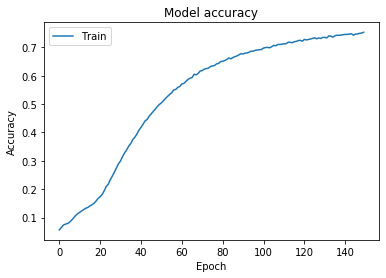

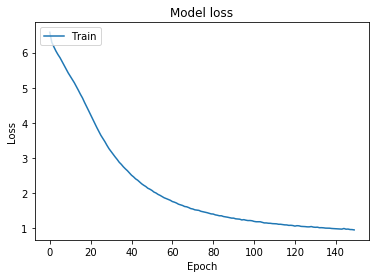

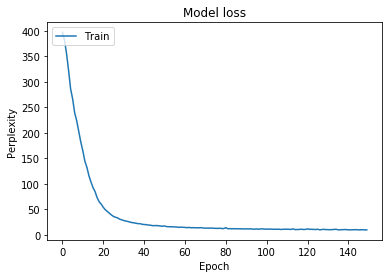

In [87]:
# Snippet taken from https://keras.io/visualization/
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation perplexity values
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])
plt.title('Model loss')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [79]:
history.history.keys()

dict_keys(['val_loss', 'val_perplexity', 'val_acc', 'loss', 'perplexity', 'acc'])

## **Load Model**

In [0]:
weight_file_path = os.path.join(OUTPUT_DIR, WEIGHT_FILE_NAME)
if os.path.exists(weight_file_path):
    # For saving : model.save(path)
    saved_model = load_model(weight_file_path)
    print('Model Loaded')
else:
    print('Model does not exist')

## **Text Generation**

In [86]:

def generate_text(model, gen_len=20, seed_text = ''):

    temps = [0.2, 0.4, 1.0]

    output = {}

    start_word = tokenizer.index_word[np.random.randint(1, len(tokenizer.word_index))-1]
    print(f'RANDOM START WORD: {start_word}')

    for temp in temps:
        input_text = start_word
        output[temp] = [input_text]
        print(f'*** For temperature: {temp}***')

        for _ in range(gen_len):
            # Generate a random initial text sequence
            bag_of_words = tokenizer.texts_to_sequences([input_text])[0]
            pad_bag_of_words = pad_sequences([bag_of_words], maxlen=max_seq_len-1, padding='pre')

            y_preds = model.predict(pad_bag_of_words, verbose=0)[0]

            idx = sample(y_preds, temp)
            # print(tokenizer.index_word[idx])
            if idx in tokenizer.index_word:
                y_pred_word = tokenizer.index_word[idx]
            output[temp].append(y_pred_word)
            input_text += ' ' + y_pred_word


        print(textwrap.fill(input_text))
        print('\n')

    for temp in output:
        output[temp] = (' ').join(output[temp])

    return output

output_text = generate_text(model, 100, seed_text='Frodo Baggins')



OUTPUT_FILE = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L'

with open(os.path.join(OUTPUT_DIR , OUTPUT_FILE+'.txt'), 'a+') as f:
    f.write('#*********New Text********\n')    
    f.write('\n\n')

    for temp in output_text:
        f.write(f'#*** For temperature: {temp} ***\n')
        f.write(textwrap.fill(output_text[temp]))
        f.write('\n\n')

    f.write('\n\n\n\n\n')


RANDOM START WORD: strode
*** For temperature: 0.2***
strode of sr 37 from the disaster and the messengers was the great
winter and the top of the tale that it was bucklanders and the fool
was in bucklanders the air was open by by fool he felt a long deal and
bucklanders and sam gamgee were bucklanders than the trees was still
and he was bucklanders and and other than they were riding in the
rising bonfire end of the red book of the forest a small was shadow in
the hand bucklanders and a small of bucklanders knew at last
bucklanders they bonfire removal and now and bucklanders


*** For temperature: 0.4***
strode of friends heart and to be both and and that he had been busy
king are topical good it was a good deal of him and as he heard the
hobbits ring to do it had been too bucklanders and what very i have
not got out bucklanders in a short whisper to do it was not for this
scent the ring is rather short known that bucklanders we have a fancy
and travel for the matter but shrewd was c